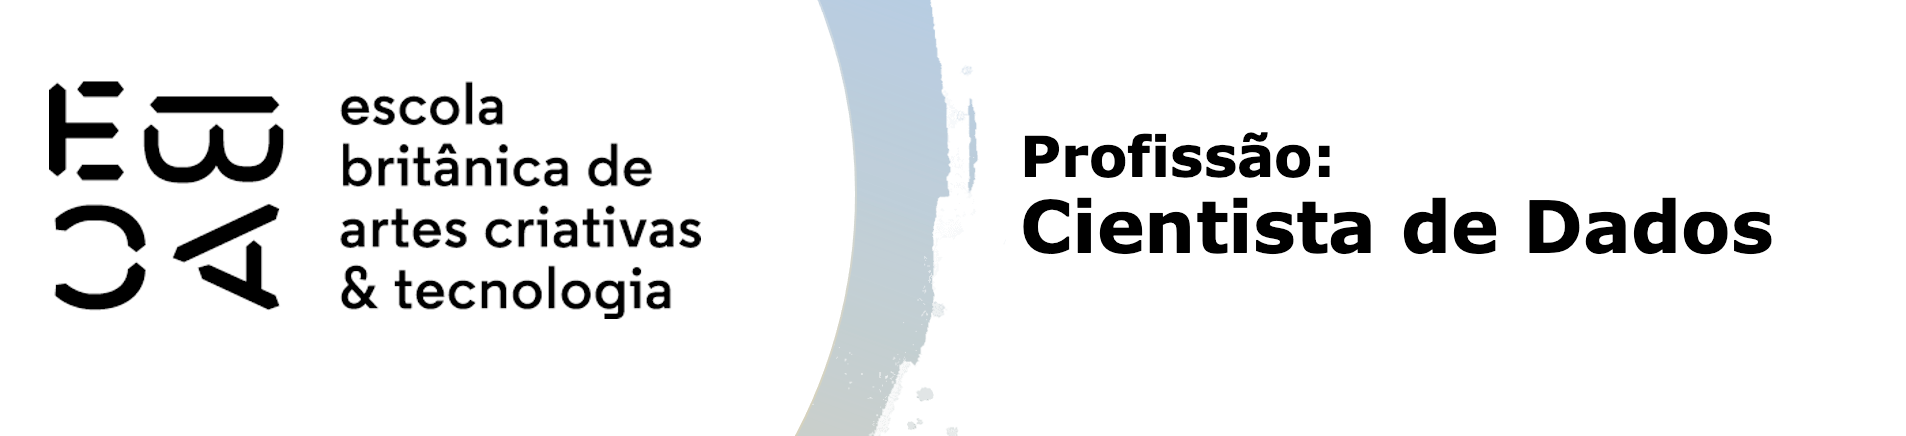

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from pycaret.classification import *
from pycaret.utils.generic import check_metric

import pickle
import joblib

import warnings;   warnings.filterwarnings("ignore")

In [2]:
df_original = pd.read_feather('credit_scoring.ftr')
print(f'A base de dados possui {df_original.shape[1]} colunas e {df_original.shape[0]} linhas, sendo elas: ')
print(df_original.info())
df_original.head()

A base de dados possui 15 colunas e 750000 linhas, sendo elas: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [3]:
# Crando uma cópia do Dataframe
df = df_original.drop(['data_ref', 'index'], axis=1)

In [4]:
# Separar as variáveis independentese a variável resposta
X = df.drop(columns=['mau'])
y = df['mau']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Variáveis categóricas e númericas
variaveis_cat = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']
variaveis_num = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

# Pipeline para as variáveis categóricas
transf_cat = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])


# Pipeline para as variáveis numéricas
transf_num = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())  
])


# Criação do pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transf_num, variaveis_num),
        ('cat', transf_cat, variaveis_cat)
    ])

# Construção do pipeline final com pré-processamento, PCA e modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=5)),
    ('classifier', LogisticRegression())
])

### Treinar um modelo de regressão logistica com o resultado

In [5]:
# Treinamento do pipeline em regressão logistica
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

acuracia = accuracy_score(y_test, y_pred)
print(f'Acurácia: {acuracia:.4f}')

Acurácia: 0.9220


In [6]:
pipeline.named_steps

{'preprocessor': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('imputer', SimpleImputer()),
                                                  ('scaler', StandardScaler())]),
                                  ['qtd_filhos', 'idade', 'tempo_emprego',
                                   'qt_pessoas_residencia', 'renda']),
                                 ('cat',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('onehot',
                                                   OneHotEncoder(drop='first'))]),
                                  ['sexo', 'posse_de_veiculo', 'posse_de_imovel',
                                   'tipo_renda', 'educacao', 'estado_civil',
                                   'tipo_residencia'])]),
 'pca': PCA(n_components=5),
 'classifier': LogisticRegression()}

In [7]:
pipeline.steps

[('preprocessor',
  ColumnTransformer(transformers=[('num',
                                   Pipeline(steps=[('imputer', SimpleImputer()),
                                                   ('scaler', StandardScaler())]),
                                   ['qtd_filhos', 'idade', 'tempo_emprego',
                                    'qt_pessoas_residencia', 'renda']),
                                  ('cat',
                                   Pipeline(steps=[('imputer',
                                                    SimpleImputer(strategy='most_frequent')),
                                                   ('onehot',
                                                    OneHotEncoder(drop='first'))]),
                                   ['sexo', 'posse_de_veiculo', 'posse_de_imovel',
                                    'tipo_renda', 'educacao', 'estado_civil',
                                    'tipo_residencia'])])),
 ('pca', PCA(n_components=5)),
 ('classifier', LogisticRegress

In [8]:
type(pipeline)

sklearn.pipeline.Pipeline

### Salvar o pickle file do modelo treinado

In [9]:
nome_arquivo = 'sklearn.pipeline.pkl'
pickle.dump(pipeline, open(nome_arquivo, 'wb'))

Tentei usar o ``pickle.dump``, mas não estava funcionando no Streamlit, então optei por usar o ``joblib.dump``.

In [10]:
joblib.dump(pipeline, 'model_regressao_logistica.pkl')

['model_regressao_logistica.pkl']

# Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [11]:
data = df.sample(frac=0.95, random_state=786)
data_unseen = df.drop(data.index)

data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (712500, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (37500, 13)


In [12]:
%%time
# Configurar o ambiente PyCaret
clf = setup(data=df, target='mau', 
            categorical_features=['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'], 
            numeric_features=['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda'],
            normalize=True, transformation=True, train_size=0.8, fold=5, session_id=123)

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(750000, 13)"
4,Transformed data shape,"(750000, 30)"
5,Transformed train set shape,"(600000, 30)"
6,Transformed test set shape,"(150000, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.8%


CPU times: total: 1min 10s
Wall time: 1min 59s


In [13]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9221,0.7796,0.0243,0.5429,0.0465,0.0401,0.1026
2,0.9223,0.7764,0.0288,0.5613,0.0547,0.0475,0.1142
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.9221,0.7817,0.0266,0.5353,0.0508,0.0437,0.1064
Mean,0.5533,0.4675,0.0159,0.3279,0.0304,0.0262,0.0646
Std,0.4518,0.3817,0.0131,0.2679,0.0250,0.0216,0.0529


In [14]:
# Ajustar os hiperparâmetros
tuned_lightgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9224,0.7866,0.0272,0.5835,0.0519,0.0453,0.1138
1,0.9222,0.7806,0.0278,0.5460,0.0529,0.0457,0.1102
2,0.9224,0.7767,0.0289,0.5729,0.0550,0.0478,0.1159
3,0.9221,0.7797,0.0288,0.5389,0.0546,0.0471,0.1111
4,0.9221,0.7823,0.0277,0.5394,0.0527,0.0454,0.1091
Mean,0.9222,0.7812,0.0281,0.5562,0.0534,0.0463,0.1120
Std,0.0001,0.0033,0.0007,0.0185,0.0012,0.0010,0.0025


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


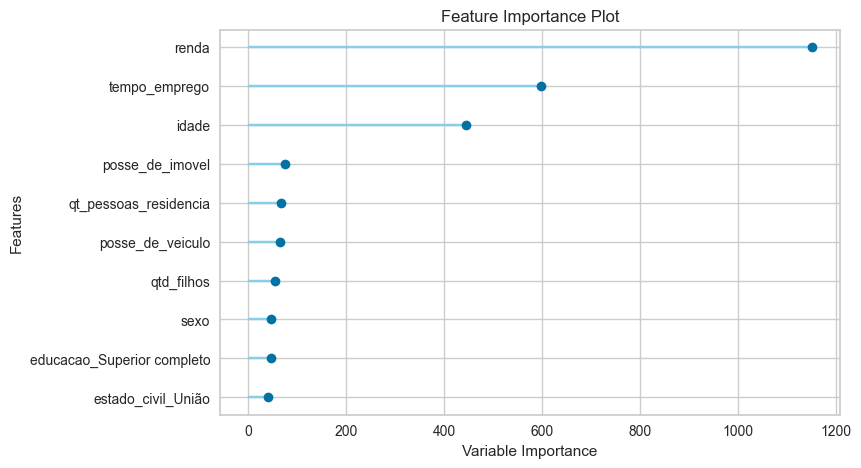

In [15]:
plot_model(tuned_lightgbm, plot='feature')

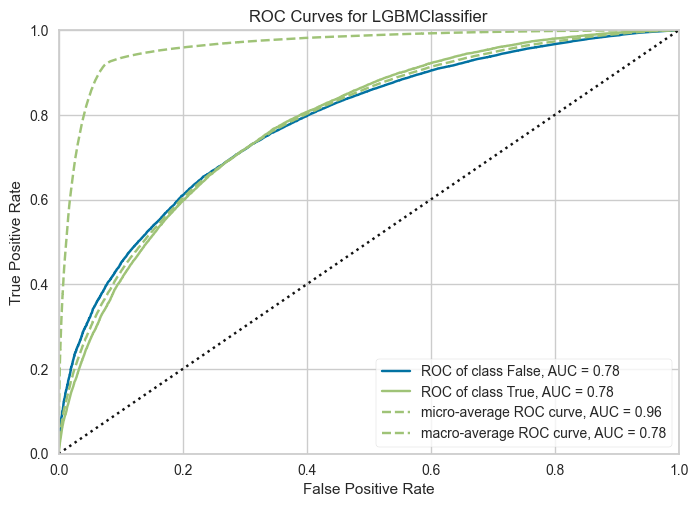

In [16]:
plot_model(tuned_lightgbm, plot='auc')

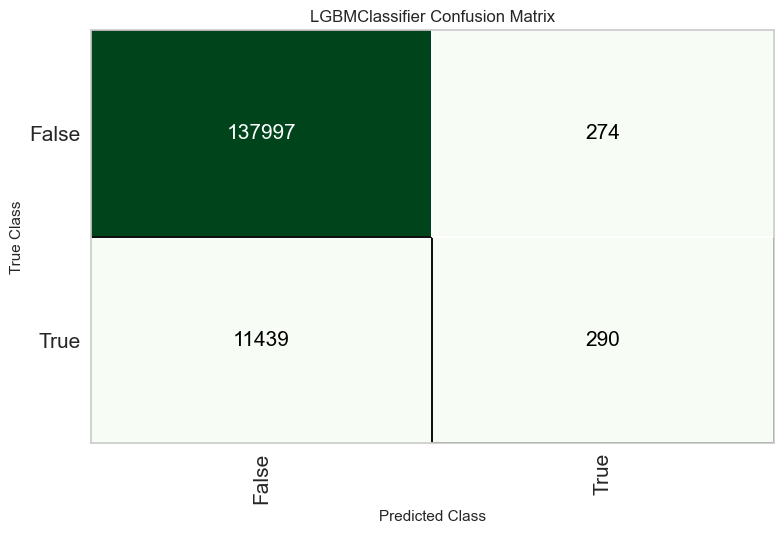

In [17]:
plot_model(tuned_lightgbm, plot='confusion_matrix')

In [18]:
# Prever nos dados não vistos
unseen_predictions = predict_model(tuned_lightgbm, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9246,0.7898,0.0320,0.5583,0.0604,0.0527,0.1203


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
0,F,S,S,2,Servidor público,Fundamental,Casado,Casa,38,15.643836,4.0,4758.299805,False,0,0.9335
1,M,N,S,1,Empresário,Médio,Casado,Casa,38,0.753425,3.0,2506.479980,False,0,0.8673
2,M,S,N,0,Empresário,Médio,Solteiro,Casa,44,1.260274,1.0,936.010010,False,0,0.7296
3,M,S,N,2,Assalariado,Médio,Casado,Casa,49,3.016438,4.0,3996.300049,False,0,0.9098
4,M,S,N,0,Empresário,Médio,Casado,Casa,39,0.827397,2.0,3908.919922,False,0,0.9047


In [19]:
acuracia = check_metric(unseen_predictions['mau'], unseen_predictions['prediction_label'], metric = 'Accuracy')
print(f'Acurácia dos modelos nos dados que não foram usados no treino: {acuracia}')

Acurácia dos modelos nos dados que não foram usados no treino: 0.9246


### Salvar o arquivo do modelo treinado

In [20]:
save_model(tuned_lightgbm, 'model_final')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
            

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
    - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.